In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Read dataset
dataset = pd.read_csv("../data/data.csv")

In [19]:
# Display first 50 rows
print(dataset[:10])

   age         workSector   education  educationNum          statusMarriage  \
0   39          State-gov   Bachelors            13           Never-married   
1   50   Self-emp-not-inc   Bachelors            13      Married-civ-spouse   
2   38            Private     HS-grad             9                Divorced   
3   53            Private        11th             7      Married-civ-spouse   
4   28            Private   Bachelors            13      Married-civ-spouse   
5   37            Private     Masters            14      Married-civ-spouse   
6   49            Private         9th             5   Married-spouse-absent   
7   52   Self-emp-not-inc     HS-grad             9      Married-civ-spouse   
8   31            Private     Masters            14           Never-married   
9   42            Private   Bachelors            13      Married-civ-spouse   

               career    relationship    race      sex  gainedCapital  \
0        Adm-clerical   Not-in-family   White     Male   

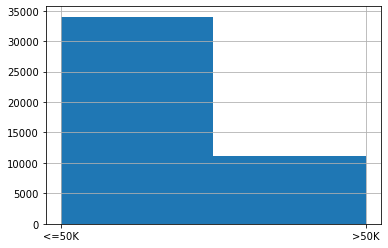

In [20]:
targets = dataset['income']
# Plot income distribution
targets.hist(bins=len(targets.unique()))

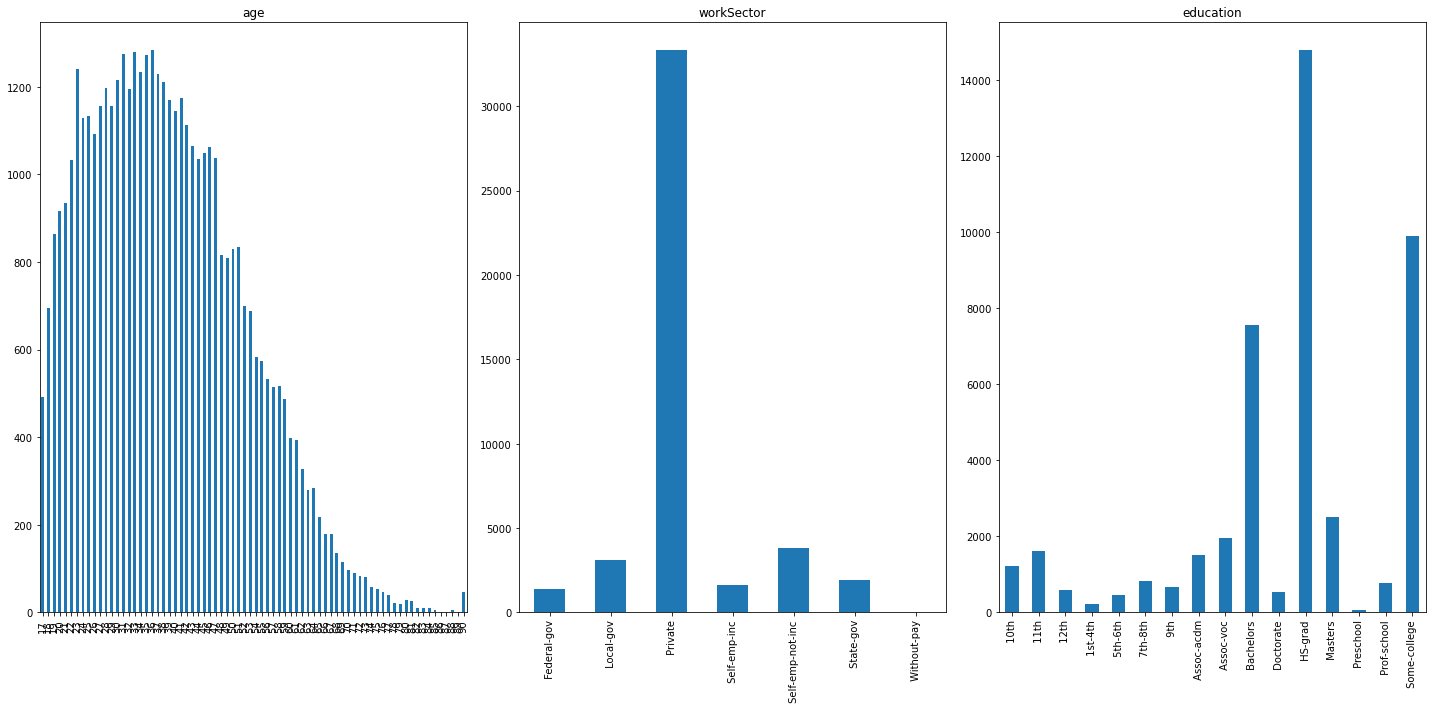

In [21]:
fig, axes = plt.subplots(ncols=3, figsize=(20,10))
for col, ax in zip(dataset[:3], axes):
    dataset[col].value_counts().sort_index().plot.bar(ax=ax, title=col)

plt.tight_layout()    
plt.show()


# pd.plotting.scatter_matrix(dataset)

In [22]:
all_features = dataset.drop(['income'], axis=1)
print(all_features.columns)

Index(['age', 'workSector', 'education', 'educationNum', 'statusMarriage',
       'career', 'relationship', 'race', 'sex', 'gainedCapital', 'lostCapital',
       'hoursPerWeek', 'country'],
      dtype='object')


In [23]:
# Replace non-numeric values using specific maps
import json

numeric_columns = dataset.select_dtypes('number').columns
not_numeric_cols = [x for x in dataset if x not in numeric_columns]

print("Numeric columns {}".format(list(numeric_columns)))
print("Not Numeric columns {}".format(not_numeric_cols))

dataset_numeric = dataset.copy()
mappings = {}
for it in not_numeric_cols:
    labels = dataset[it].unique().tolist()
    mapping = dict(zip(labels, range(len(labels))))
    mappings[it] = mapping
    dataset_numeric.replace({it:mapping}, inplace=True)

print(dataset_numeric[not_numeric_cols])
print(mappings)

with open("mapping.json", 'w') as f:
    json.dump(mappings, f)

Numeric columns ['age', 'educationNum', 'gainedCapital', 'lostCapital', 'hoursPerWeek']
Not Numeric columns ['workSector', 'education', 'statusMarriage', 'career', 'relationship', 'race', 'sex', 'country', 'income']
       workSector  education  statusMarriage  career  relationship  race  sex  \
0               0          0               0       0             0     0    0   
1               1          0               1       1             1     0    0   
2               2          1               2       2             0     0    0   
3               2          2               1       2             1     1    0   
4               2          0               1       3             2     1    1   
...           ...        ...             ...     ...           ...   ...  ...   
45217           2          0               0       3             3     0    0   
45218           2          0               2       3             0     0    1   
45219           2          0               1       3   

In [24]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset_numeric, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

28941 train examples
7236 validation examples
9045 test examples


In [42]:
from tensorflow import feature_column
from tensorflow.keras import layers
import tensorflow as tf

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('income')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds


batch_size = 2
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [43]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of country:', feature_batch['country'])
  print('A batch of targets:', label_batch )
  break

Every feature: ['age', 'workSector', 'education', 'educationNum', 'statusMarriage', 'career', 'relationship', 'race', 'sex', 'gainedCapital', 'lostCapital', 'hoursPerWeek', 'country']
A batch of country: Tensor("IteratorGetNext_73760:2", shape=(?,), dtype=int64)
A batch of targets: Tensor("IteratorGetNext_73760:13", shape=(?,), dtype=int64)


In [44]:
headers = list(all_features.columns)
print("Feature Columns: {}".format(headers))


feature_columns = []
for header in headers:
  feature_columns.append(feature_column.numeric_column(header))

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)


model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Feature Columns: ['age', 'workSector', 'education', 'educationNum', 'statusMarriage', 'career', 'relationship', 'race', 'sex', 'gainedCapital', 'lostCapital', 'hoursPerWeek', 'country']
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
14471/14471 [==============================] - 64s 4ms/step - loss: 2.9881 - acc: 0.7859 - val_loss: 0.4488 - val_acc: 0.7452
Epoch 2/10
14471/14471 [==============================] - 29s 2ms/step - loss: 0.4170 - acc: 0.7776 - val_loss: 0.4118 - val_acc: 0.7736
Epoch 3/10
14471/14471 [==============================] - 29s 2ms/step - loss: 0.4021 - acc: 0.7835 - val_loss: 0.4157 - val_acc: 0.7482
Epoch 4/10
14471/14471 [==============================] - 29s 2ms/step - loss: 0.3928 - acc: 0.7910 - val_loss: 0.3994 - val_acc: 0.8078
Epoch 5/10
14471/14471 [==============================

In [45]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

4523/4523 [==============================] - 20s 4ms/step - loss: 0.3742 - acc: 0.8292
Accuracy 0.8291874
